In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_data():
    # Tải dữ liệu hoa diên vĩ
    iris = load_iris()
    X = iris.data  # Đặc trưng: sepal length, sepal width, petal length, petal width
    y = iris.target  # Nhãn: 0 (Setosa), 1 (Versicolor), 2 (Virginica)
    
    # Chuyển nhãn sang one-hot encoding
    encoder = OneHotEncoder(sparse_output=False)
    y_one_hot = encoder.fit_transform(y.reshape(-1, 1))
    
    return X, y_one_hot, y, iris.target_names

In [3]:
def normalize_data(X):
    # Chuẩn hóa dữ liệu về khoảng [0, 1]
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    return (X - X_min) / (X_max - X_min)

In [ ]:
class ANN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # Khởi tạo trọng số với giá trị ngẫu nhiên nhỏ
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, X):
        # Lan truyền tiến qua mạng nơ-ron
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)  # Đầu ra của lớp ẩn
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)  # Đầu ra của mạng
        return self.a2
    
    def backward(self, X, y):
        # Lan truyền ngược
        m = X.shape[0]
        
        # Tính lỗi ở lớp đầu ra
        dZ2 = self.a2 - y
        dW2 = (1/m) * np.dot(self.a1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        
        # Tính lỗi ở lớp ẩn
        dZ1 = np.dot(dZ2, self.W2.T) * self.sigmoid_derivative(self.a1)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        
        # Cập nhật trọng số sử dụng gradient descent
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    def train(self, X, y, epochs=1000):
        losses = []
        for epoch in range(epochs):
            # Lan truyền tiến
            output = self.forward(X)
            
            # Tính hàm lỗi (mean squared error)
            loss = np.mean(np.square(y - output))
            losses.append(loss)
            
            # Lan truyền ngược
            self.backward(X, y)
            
            # In lỗi sau mỗi 100 epoch
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        
        return losses
    
    def predict(self, X):
        # Dự đoán đầu ra
        output = self.forward(X)
        # Chuyển về nhãn one-hot
        return np.argmax(output, axis=1)

In [20]:
def evaluate_model(X, y, y_original, hidden_sizes, learning_rates, k=5, epochs=1000):
    results = []
    
    # Chuẩn hóa dữ liệu
    X_normalized = normalize_data(X)
    
    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            print(f"\nĐánh giá mô hình với {hidden_size} nơ-ron ẩn và learning rate = {lr}")
            
            # Khởi tạo KFold
            kf = KFold(n_splits=k, shuffle=True, random_state=42)
            
            fold_accuracies = []
            fold_recalls = []
            fold_precisions = []
            fold_confusion_matrices = []
            
            # Lặp qua từng fold
            for fold, (train_index, test_index) in enumerate(kf.split(X_normalized)):
                # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
                X_train, X_test = X_normalized[train_index], X_normalized[test_index]
                y_train_one_hot, y_test_one_hot = y[train_index], y[test_index]
                y_test_original = y_original[test_index]
                
                # Khởi tạo mô hình ANN
                input_size = X.shape[1]  # Số đặc trưng đầu vào
                output_size = y.shape[1]  # Số lớp
                model = ANN(input_size, hidden_size, output_size, lr)
                
                # Huấn luyện mô hình
                print(f"Fold {fold+1}/{k}:")
                model.train(X_train, y_train_one_hot, epochs=epochs)
                
                # Dự đoán trên tập kiểm tra
                y_pred = model.predict(X_test)
                
                # Tính các chỉ số đánh giá
                accuracy = accuracy_score(y_test_original, y_pred)
                recall = recall_score(y_test_original, y_pred, average='macro')
                precision = precision_score(y_test_original, y_pred, average='macro', zero_division=0)
                cm = confusion_matrix(y_test_original, y_pred)
                
                fold_accuracies.append(accuracy)
                fold_recalls.append(recall)
                fold_precisions.append(precision)
                fold_confusion_matrices.append(cm)
                
                print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")
                print("Confusion Matrix:")
                print(cm)
            
            # Tính giá trị trung bình của các chỉ số
            avg_accuracy = np.mean(fold_accuracies)
            avg_recall = np.mean(fold_recalls)
            avg_precision = np.mean(fold_precisions)
            
            print(f"\nKết quả trung bình ({k}-fold cross validation):")
            print(f"Hidden size: {hidden_size}, Learning rate: {lr}")
            print(f"Accuracy: {avg_accuracy:.4f}, Recall: {avg_recall:.4f}, Precision: {avg_precision:.4f}")
            
            # Lưu kết quả
            results.append({
                'hidden_size': hidden_size,
                'learning_rate': lr,
                'accuracy': avg_accuracy,
                'recall': avg_recall,
                'precision': avg_precision,
                'confusion_matrices': fold_confusion_matrices
            })
    
    return results

In [21]:
def plot_results(results):
    # Chuyển kết quả thành DataFrame
    df_results = pd.DataFrame([
        {
            'hidden_size': r['hidden_size'],
            'learning_rate': r['learning_rate'],
            'accuracy': r['accuracy'],
            'recall': r['recall'],
            'precision': r['precision']
        }
        for r in results
    ])
    
    # Tạo bảng pivot để vẽ heatmap
    pivot_accuracy = df_results.pivot(index='hidden_size', columns='learning_rate', values='accuracy')
    pivot_recall = df_results.pivot(index='hidden_size', columns='learning_rate', values='recall')
    pivot_precision = df_results.pivot(index='hidden_size', columns='learning_rate', values='precision')
    
    # Tìm mô hình tốt nhất
    best_model = df_results.loc[df_results['accuracy'].idxmax()]
    
    # Vẽ heatmap cho accuracy
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.heatmap(pivot_accuracy, annot=True, cmap='viridis', fmt='.4f')
    plt.title('Accuracy by Hidden Size and Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Hidden Size')
    
    plt.subplot(1, 3, 2)
    sns.heatmap(pivot_recall, annot=True, cmap='viridis', fmt='.4f')
    plt.title('Recall by Hidden Size and Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Hidden Size')
    
    plt.subplot(1, 3, 3)
    sns.heatmap(pivot_precision, annot=True, cmap='viridis', fmt='.4f')
    plt.title('Precision by Hidden Size and Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Hidden Size')
    
    plt.tight_layout()
    plt.savefig('iris_ann_results.png')
    plt.show()
    
    # Vẽ ma trận nhầm lẫn cho mô hình tốt nhất
    best_idx = df_results['accuracy'].idxmax()
    best_cms = results[best_idx]['confusion_matrices']
    
    # Tính ma trận nhầm lẫn trung bình
    avg_cm = np.mean(best_cms, axis=0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues')
    plt.title(f'Average Confusion Matrix\nHidden Size: {best_model["hidden_size"]}, Learning Rate: {best_model["learning_rate"]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('iris_ann_confusion_matrix.png')
    plt.show()
    
    return best_model

In [ ]:
def plot_all_confusion_matrices(results, df_results):
    # Lấy tên các lớp
    iris = load_iris()
    class_names = iris.target_names
    
    # Tạo một bảng tổng hợp tất cả các ma trận nhầm lẫn
    plt.figure(figsize=(15, 10))
    
    # Tính số hàng và số cột cho subplot
    num_configs = len(results)
    cols = 3  # Số cột trong layout
    rows = (num_configs + cols - 1) // cols  # Số hàng cần thiết
    
    for i, result in enumerate(results):
        hidden_size = result['hidden_size']
        lr = result['learning_rate']
        cms = result['confusion_matrices']
        
        # Tính ma trận nhầm lẫn trung bình
        avg_cm = np.mean(cms, axis=0)
        
        # Tính các chỉ số từ ma trận
        accuracy = np.trace(avg_cm) / np.sum(avg_cm)
        
        # Tạo subplot
        plt.subplot(rows, cols, i + 1)
        sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues', cbar=False)
        plt.title(f'Hidden: {hidden_size}, LR: {lr}\nAcc: {accuracy:.4f}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        # Thêm nhãn lớp nếu là subplot cuối cùng
        if i == num_configs - 1:
            tick_marks = np.arange(len(class_names))
            plt.xticks(tick_marks + 0.5, class_names, rotation=45)
            plt.yticks(tick_marks + 0.5, class_names)
    
    plt.tight_layout()
    plt.savefig('all_confusion_matrices.png')
    plt.show()
    
    # Tạo bảng tổng hợp chi tiết
    cm_summary = []
    
    for i, result in enumerate(results):
        hidden_size = result['hidden_size']
        lr = result['learning_rate']
        cms = result['confusion_matrices']
        
        # Tính ma trận nhầm lẫn trung bình
        avg_cm = np.mean(cms, axis=0)
        
        # Tính các chỉ số phân loại chi tiết cho từng lớp
        class_metrics = []
        
        for c in range(len(class_names)):
            # True Positives, False Positives, False Negatives
            tp = avg_cm[c, c]
            fp = np.sum(avg_cm[:, c]) - tp
            fn = np.sum(avg_cm[c, :]) - tp
            
            # Tính precision và recall cho lớp này
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            class_metrics.append({
                'class': class_names[c],
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
        
        cm_summary.append({
            'hidden_size': hidden_size,
            'learning_rate': lr,
            'accuracy': result['accuracy'],
            'class_metrics': class_metrics
        })
    
    # In bảng tổng hợp
    print("\n=== BẢNG TỔNG HỢP KẾT QUẢ ===")
    for summary in cm_summary:
        print(f"\nẨn: {summary['hidden_size']}, LR: {summary['learning_rate']}, Acc: {summary['accuracy']:.4f}")
        print("Chi tiết từng lớp:")
        for metric in summary['class_metrics']:
            print(f"  {metric['class']}: Precision={metric['precision']:.4f}, Recall={metric['recall']:.4f}, F1={metric['f1']:.4f}")
    
    # Tìm mô hình tốt nhất theo accuracy và theo F1
    best_acc_idx = df_results['accuracy'].idxmax()
    
    # Tính điểm F1 trung bình cho mỗi mô hình
    f1_scores = []
    for summary in cm_summary:
        avg_f1 = np.mean([m['f1'] for m in summary['class_metrics']])
        f1_scores.append(avg_f1)
    
    best_f1_idx = np.argmax(f1_scores)
    
    print("\n=== MÔ HÌNH TỐT NHẤT ===")
    print(f"Theo Accuracy: Ẩn={results[best_acc_idx]['hidden_size']}, LR={results[best_acc_idx]['learning_rate']}, Acc={results[best_acc_idx]['accuracy']:.4f}")
    print(f"Theo F1-Score: Ẩn={results[best_f1_idx]['hidden_size']}, LR={results[best_f1_idx]['learning_rate']}, F1={f1_scores[best_f1_idx]:.4f}")
    
    # Vẽ đồ thị so sánh F1-score cho các lớp ở các cấu hình khác nhau
    f1_by_class = np.zeros((len(results), len(class_names)))
    config_labels = []
    
    for i, summary in enumerate(cm_summary):
        config_labels.append(f"Hidden:{summary['hidden_size']}, LR:{summary['learning_rate']}")
        for j, metric in enumerate(summary['class_metrics']):
            f1_by_class[i, j] = metric['f1']
    
    plt.figure(figsize=(12, 8))
    x = np.arange(len(config_labels))
    width = 0.25
    
    for i in range(len(class_names)):
        plt.bar(x + i*width, f1_by_class[:, i], width, label=class_names[i])
    
    plt.xlabel('Cấu hình mô hình')
    plt.ylabel('F1-Score')
    plt.title('So sánh F1-Score cho từng lớp ở các cấu hình khác nhau')
    plt.xticks(x + width, config_labels, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig('f1_comparison.png')
    plt.show()


Thông tin về dữ liệu hoa diên vĩ:
Số lượng mẫu: 150
Số đặc trưng: 4
Các lớp: ['setosa' 'versicolor' 'virginica']
Phân bố lớp: [50 50 50]

Thống kê mô tả của dữ liệu:
       sepal length  sepal width  petal length  petal width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


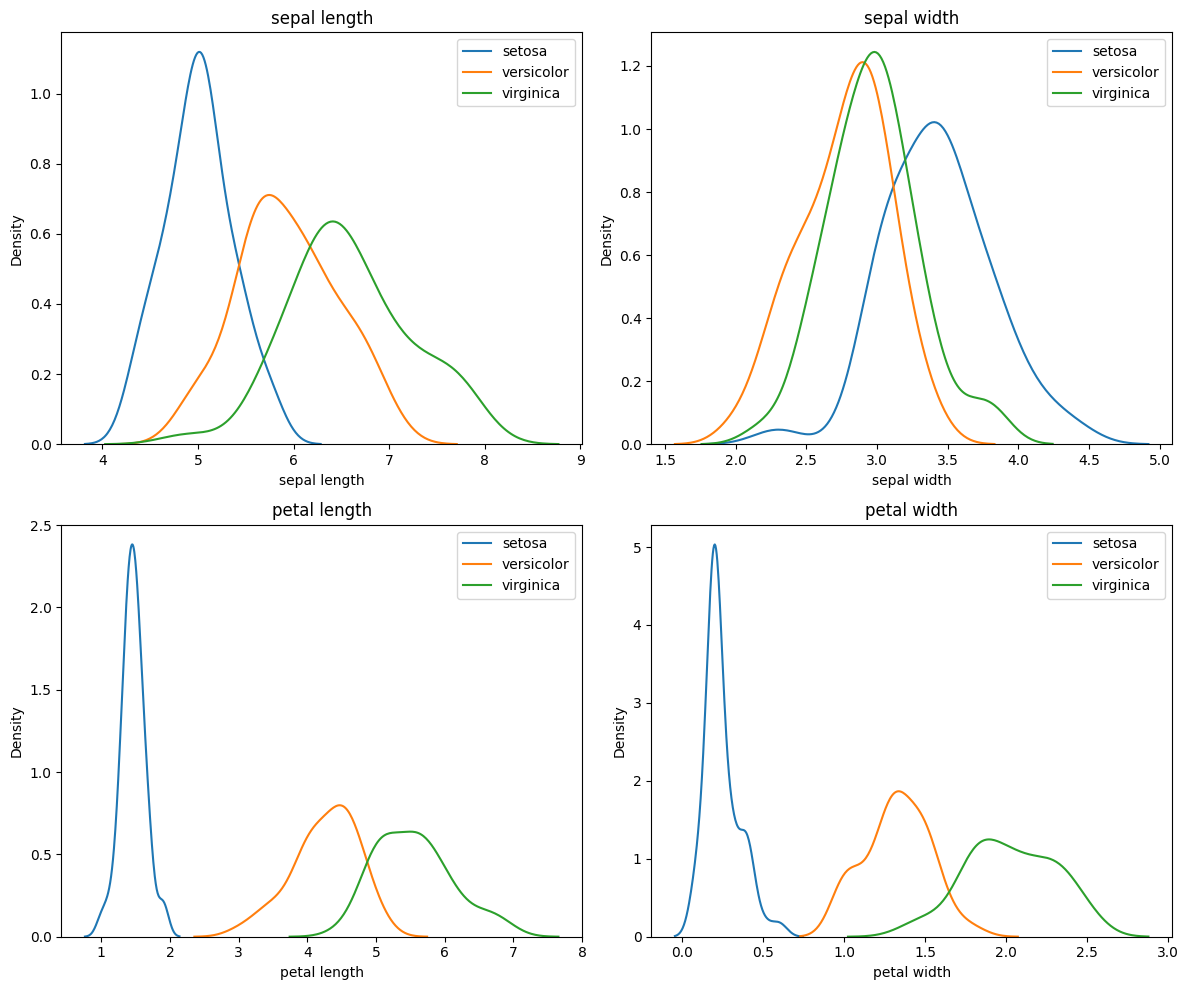


Đánh giá mô hình với 10 nơ-ron ẩn và learning rate = 0.05
Fold 1/5:
Epoch 0, Loss: 0.2506
Epoch 100, Loss: 0.2222
Epoch 200, Loss: 0.2222
Epoch 300, Loss: 0.2221
Epoch 400, Loss: 0.2221
Epoch 500, Loss: 0.2220
Epoch 600, Loss: 0.2219
Epoch 700, Loss: 0.2217
Epoch 800, Loss: 0.2213
Epoch 900, Loss: 0.2205
Fold 1 - Accuracy: 0.3000, Recall: 0.3333, Precision: 0.1000
Confusion Matrix:
[[ 0 10  0]
 [ 0  9  0]
 [ 0 11  0]]
Fold 2/5:
Epoch 0, Loss: 0.2511
Epoch 100, Loss: 0.2218
Epoch 200, Loss: 0.2218
Epoch 300, Loss: 0.2217
Epoch 400, Loss: 0.2217
Epoch 500, Loss: 0.2216
Epoch 600, Loss: 0.2214
Epoch 700, Loss: 0.2212
Epoch 800, Loss: 0.2207
Epoch 900, Loss: 0.2200
Fold 2 - Accuracy: 0.2333, Recall: 0.3333, Precision: 0.0778
Confusion Matrix:
[[ 0  0 13]
 [ 0  0 10]
 [ 0  0  7]]
Fold 3/5:
Epoch 0, Loss: 0.2500
Epoch 100, Loss: 0.2220
Epoch 200, Loss: 0.2220
Epoch 300, Loss: 0.2220
Epoch 400, Loss: 0.2220
Epoch 500, Loss: 0.2219
Epoch 600, Loss: 0.2218
Epoch 700, Loss: 0.2215
Epoch 800, Lo

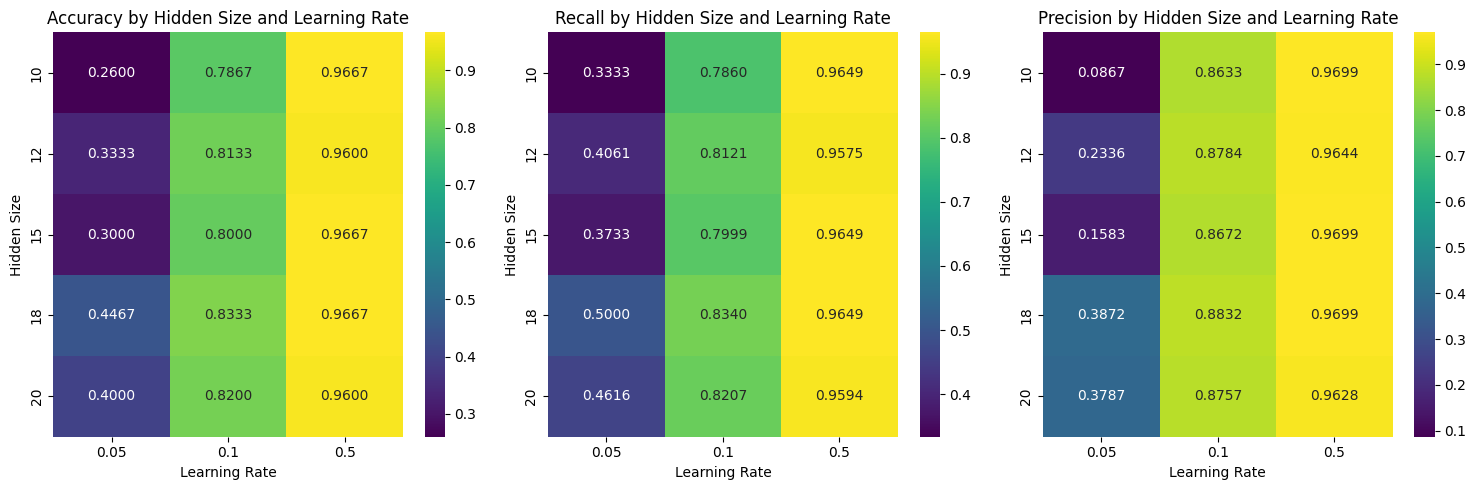

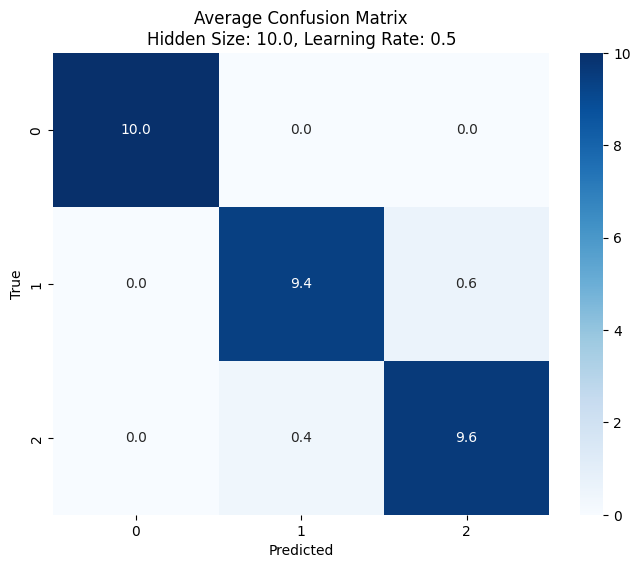


Mô hình tốt nhất:
Hidden Size: 10.0
Learning Rate: 0.5
Accuracy: 0.9667
Recall: 0.9649
Precision: 0.9699


In [23]:
if __name__ == "__main__":
    # Tải dữ liệu
    X, y_one_hot, y_original, class_names = load_data()
    
    # Định nghĩa các tham số cần thử nghiệm
    hidden_sizes = [10, 12, 15, 18, 20]
    learning_rates = [0.05, 0.1, 0.5]
    
    # Hiển thị thông tin về dữ liệu
    print("\nThông tin về dữ liệu hoa diên vĩ:")
    print(f"Số lượng mẫu: {X.shape[0]}")
    print(f"Số đặc trưng: {X.shape[1]}")
    print(f"Các lớp: {class_names}")
    print(f"Phân bố lớp: {np.bincount(y_original)}")
    
    # Hiển thị thống kê mô tả của dữ liệu
    df = pd.DataFrame(X, columns=['sepal length', 'sepal width', 'petal length', 'petal width'])
    df['species'] = [class_names[i] for i in y_original]
    
    print("\nThống kê mô tả của dữ liệu:")
    print(df.describe())
    
    # Vẽ phân phối của các đặc trưng theo lớp
    plt.figure(figsize=(12, 10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        for j in range(3):
            sns.kdeplot(df.iloc[y_original == j, i], label=class_names[j])
        plt.title(df.columns[i])
        plt.legend()
    plt.tight_layout()
    plt.savefig('feature_distributions.png')
    plt.show()
    
    # Đánh giá mô hình với các tham số khác nhau
    results = evaluate_model(X, y_one_hot, y_original, hidden_sizes, learning_rates, k=5, epochs=1000)
    
    # Vẽ đồ thị kết quả
    best_model = plot_results(results)
    
    print("\nMô hình tốt nhất:")
    print(f"Hidden Size: {best_model['hidden_size']}")
    print(f"Learning Rate: {best_model['learning_rate']}")
    print(f"Accuracy: {best_model['accuracy']:.4f}")
    print(f"Recall: {best_model['recall']:.4f}")
    print(f"Precision: {best_model['precision']:.4f}")
    
    # Tạo và lưu báo cáo tổng hợp
    report = f"""
    # BÁO CÁO PHÂN LOẠI HOA DIÊN VĨ SỬ DỤNG ANN
    
    ## Thông tin dữ liệu
    - Số lượng mẫu: {X.shape[0]}
    - Số đặc trưng: {X.shape[1]}
    - Các lớp: {', '.join(class_names)}
    - Phân bố lớp: {np.bincount(y_original)}
    
    ## Cấu hình mô hình
    - Số nơ-ron lớp ẩn đã thử: {hidden_sizes}
    - Tốc độ học đã thử: {learning_rates}
    - Phương pháp đánh giá: {5}-fold cross validation
    
    ## Kết quả tốt nhất
    - Số nơ-ron lớp ẩn tốt nhất: {best_model['hidden_size']}
    - Tốc độ học tốt nhất: {best_model['learning_rate']}
    - Accuracy: {best_model['accuracy']:.4f}
    - Recall: {best_model['recall']:.4f}
    - Precision: {best_model['precision']:.4f}
    """
    
    with open('iris_ann_report.md', 'w', encoding='utf-8') as f:
        f.write(report)